# 確率密度関数 (PDF)

ヒストグラム法で推定する．


In [162]:
import matplotlib.pyplot as plt
import pandas as pd

# comment out below
import json


def dict2rc(dict): return {f'{k1}.{k2}': v for k1,
                           d in dict.items() for k2, v in d.items()}


with open('mpl_rc.json') as f:
    plt.rcParams.update(dict2rc(json.load(f)))
plt.style.use('dracula')


In [163]:
path = '../data/kanazawa2017-2019_min.csv'
data = pd.read_csv(path, header=None)
data.columns = ['ymd', 'time', 'temperature']
data.head()


,ymd,time,temperature
0,2017/1/1,1:00,7.5
1,2017/1/1,2:00,7.4
2,2017/1/1,3:00,6.8
3,2017/1/1,4:00,6.3
4,2017/1/1,5:00,5.9


In [164]:
# 統計量をまとめて確認
data.describe()


,temperature
count,26279.000000
mean,15.476053
std,8.988614
min,-3.500000
25%,7.600000
50%,15.700000
75%,22.900000
max,37.300000


## Dictionary 型を使う

- Count するとき，key が存在するかで処理を分ける
- 辞書の key はソートされていないので，ソート処理が必要

In [165]:
import math


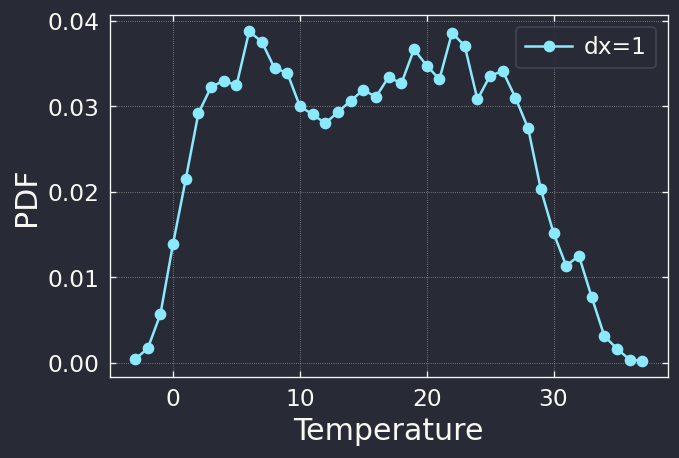

In [166]:
def calc_pdf(xs, dx=1):
    # xs  : データの１次元配列
    # dx: bin幅

    xmin = int(min(xs)) - dx/2  # binの中央値を整数にするための調整

    counter = dict()
    for x in xs:
        index = int((x-xmin)/dx)
        if index in counter:
            counter[index] += 1
        else:
            counter[index] = 1

    pdf = dict()
    N = len(xs) * dx
    for index, count in counter.items():
        xbin = xmin + (index+0.5) * dx
        pdf[xbin] = count / N

    # binでソートする
    pdf = dict(sorted(pdf.items(), key=lambda d: d[0]))

    return pdf


def draw_pdf(pdf, label=None):
    x = pdf.keys()
    p = pdf.values()
    plt.plot(x, p, marker='o', label=label)
    # plt.bar(x, p)
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


pdf = calc_pdf(data['temperature'], dx=1)
draw_pdf(pdf, label=f'dx=1')


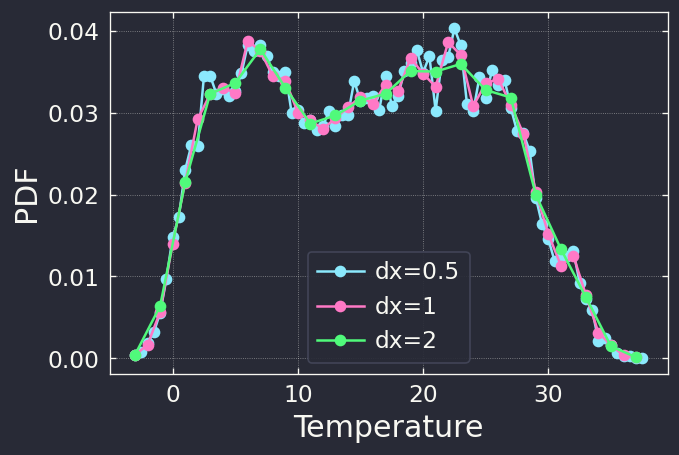

In [168]:
for dx in [0.5, 1, 2]:
    pdf = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(pdf, label=f'dx={dx}')


## collections.Counter() を使う

- 標準ライブラリ `collections` を import する
- Count するとき，key が存在するかで処理を分ける必要なし！
- 辞書の key はソートされていないので，ソート処理が必要

In [169]:
import collections


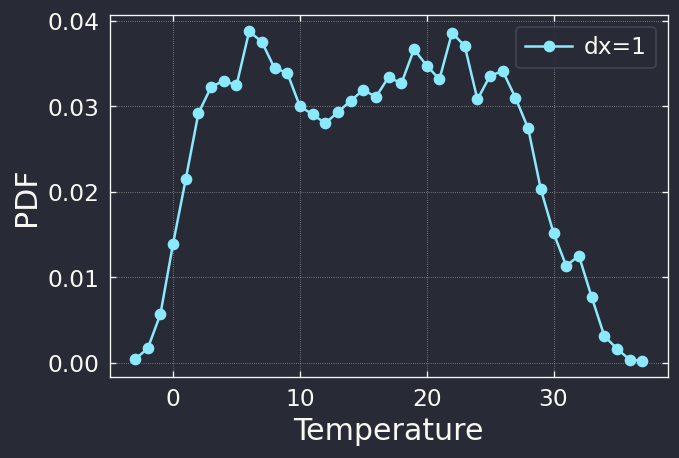

In [170]:
def calc_pdf(xs, dx=1):
    # xs  : データの１次元配列
    # dx: bin幅

    xmin = int(min(xs)) - dx/2  # binの中央値を整数にするための調整
    counter = collections.Counter()
    for x in xs:
        index = int((x-xmin)/dx)  # binの左側に値を保存
        counter[index] += 1

    pdf = dict()
    N = len(xs) * dx
    for index, count in counter.items():
        xbin = xmin + (index+0.5) * dx
        pdf[xbin] = count / N

    # binでソートする
    pdf = dict(sorted(pdf.items(), key=lambda d: d[0]))

    return pdf


def draw_pdf(pdf, label=None):
    x = pdf.keys()
    p = pdf.values()
    plt.plot(x, p, marker='o', label=label)
    # plt.bar(x, p)
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


pdf = calc_pdf(data['temperature'], dx=1)
draw_pdf(pdf, label=f'dx=1')


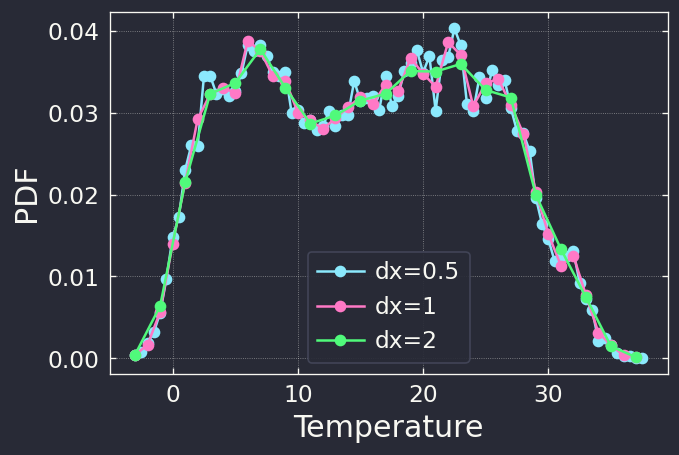

In [171]:
for dx in [0.5, 1, 2]:
    pdf = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(pdf, label=f'dx={dx}')


## Pandas.Series.value_counts() を使う

In [172]:
import numpy as np


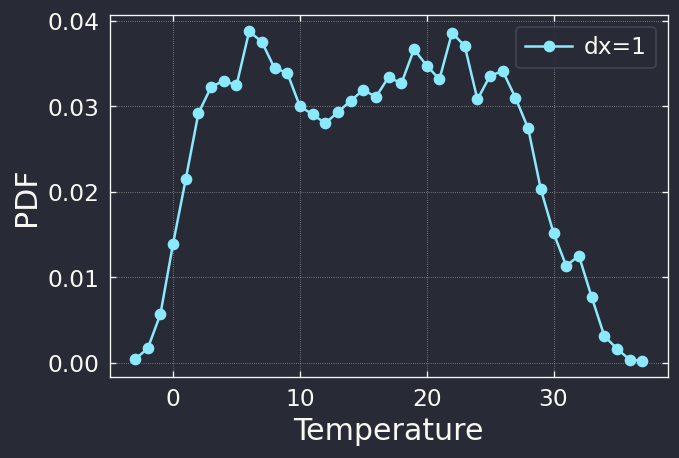

In [173]:
def calc_pdf(xs, dx=1):
    # xs  : データの１次元配列
    # dx: bin幅

    xmin = int(min(xs)) - dx/2  # binの中央値を整数にするための調整
    indices = np.floor((xs-xmin)/dx)
    pdf = indices.value_counts(normalize=True) / dx
    pdf.index = xmin + (pdf.index + 0.5) * dx
    pdf = pdf.sort_index()

    return pdf


def draw_pdf(pdf, label=None):
    x = pdf.index
    p = pdf.values
    plt.plot(x, p, marker='o', label=label)
    # plt.bar(x, p)
    plt.xlabel('Temperature')
    plt.ylabel('PDF')
    plt.legend()


pdf = calc_pdf(data['temperature'], dx=1)
draw_pdf(pdf, label=f'dx=1')


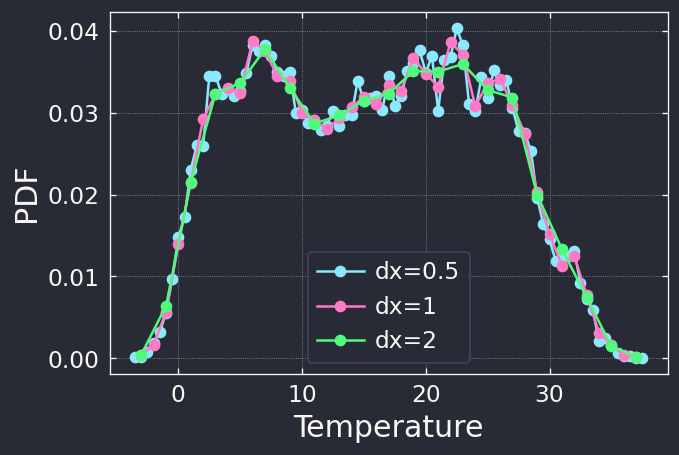

In [174]:
for dx in [0.5, 1, 2]:
    pdf = calc_pdf(data['temperature'], dx=dx)
    draw_pdf(pdf, label=f'dx={dx}')


## 整数変換に関する注意点

- 切り捨て, 偶数丸め, 四捨五入, 切り上げ
- マイナスの値の処理（今回は関係ない）

In [175]:
import math
for x in [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]:
    print(f'math.floor({x})={math.floor(x)}', end=', ')
    print(f'int({x})={int(x)}', end=', ')
    print(f'round({x})={round(x)}', end=', ')
    print(f'math.ceil({x})={math.ceil(x)}', end='\n')


math.floor(-1.5)=-2, int(-1.5)=-1, round(-1.5)=-2, math.ceil(-1.5)=-1
math.floor(-0.5)=-1, int(-0.5)=0, round(-0.5)=0, math.ceil(-0.5)=0
math.floor(0.5)=0, int(0.5)=0, round(0.5)=0, math.ceil(0.5)=1
math.floor(1.5)=1, int(1.5)=1, round(1.5)=2, math.ceil(1.5)=2
math.floor(2.5)=2, int(2.5)=2, round(2.5)=2, math.ceil(2.5)=3
math.floor(3.5)=3, int(3.5)=3, round(3.5)=4, math.ceil(3.5)=4
